In [3]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np

# Если в будущем понадобятся графики — раскомментируйте
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# Загрузка датасета
df = pd.read_csv('S05-hw-dataset.csv')

# 1. Первые строки датасета
print("Первые 5 строк датасета:")
print(df.head())

print("\n" + "="*50 + "\n")

# 2. Информация о столбцах и типах данных
print("Информация о датасете:")
df.info()

print("\n" + "="*50 + "\n")

# 3. Базовые описательные статистики для числовых признаков
print("Описательные статистики:")
print(df.describe())

print("\n" + "="*50 + "\n")

# 4. Распределение целевого признака default
print("Распределение целевой переменной 'default':")
print(df['default'].value_counts())

print("\nПроцентное распределение:")
print(df['default'].value_counts(normalize=True).round(4) * 100)

# Дополнительно: общая информация о размере датасета
print(f"\nРазмер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Пропущенные значения:\n{df.isnull().sum().sum()} (всего)")

Первые 5 строк датасета:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229        

Датасет содержит **3000 объектов** и **17 признаков** (включая целевую переменную `default` и идентификатор `client_id`).

Явные аномалии: отрицательные значения в `checking_balance` (до -3000), что может указывать на овердрафт и является допустимым; минимальный доход 15 000 выглядит низким, но возможным; других явно невозможных значений (например, отрицательный возраст или стаж) не обнаружено.

Целевая переменная `default` распределена следующим образом: **59%** объектов класса 0 (нет дефолта), **41%** класса 1 (дефолт) — умеренный дисбаланс классов, но не критичный для большинства моделей.

In [4]:
# Вектор таргета
y = df['default']

# Матрица признаков (исключаем target и client_id)
X = df.drop(columns=['default', 'client_id'])

# Проверка размеров
X.shape, y.shape


((3000, 15), (3000,))

In [5]:
# проверка на то, что все используемые признаки числовые
X.dtypes

age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

In [6]:
# Проверка диапазонов значений
X['debt_to_income'].min(), X['debt_to_income'].max()

(np.float64(0.0061471149847966), np.float64(0.878343349584274))

In [7]:
from sklearn.model_selection import train_test_split

# Для оценки качества моделей разделим данные на обучающую и тестовую выборки.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Проверка размеров выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2400, 15), (600, 15), (2400,), (600,))

In [8]:
from sklearn.dummy import DummyClassifier

# Инициализация бейзлайн-модели
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

# Обучение
dummy_clf.fit(X_train, y_train)


,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'most_frequent'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


In [9]:
# Оценка бейзлайн-модели (DummyClassifier)
from sklearn.metrics import accuracy_score, roc_auc_score

# Предсказания классов
y_pred_dummy = dummy_clf.predict(X_test)

# Предсказания вероятностей
y_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

# Метрики качества
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

accuracy_dummy, roc_auc_dummy


(0.59, 0.5)

Лучшие параметры: {'logreg__C': 10.0, 'logreg__solver': 'liblinear'}
Лучшее ROC-AUC на кросс-валидации: 0.8607

Метрики на тестовой выборке:
Accuracy:  0.8000
ROC-AUC:   0.8757
Precision: 0.7944
Recall:    0.6911
F1-score:  0.7391

Confusion Matrix:
[[310  44]
 [ 76 170]]


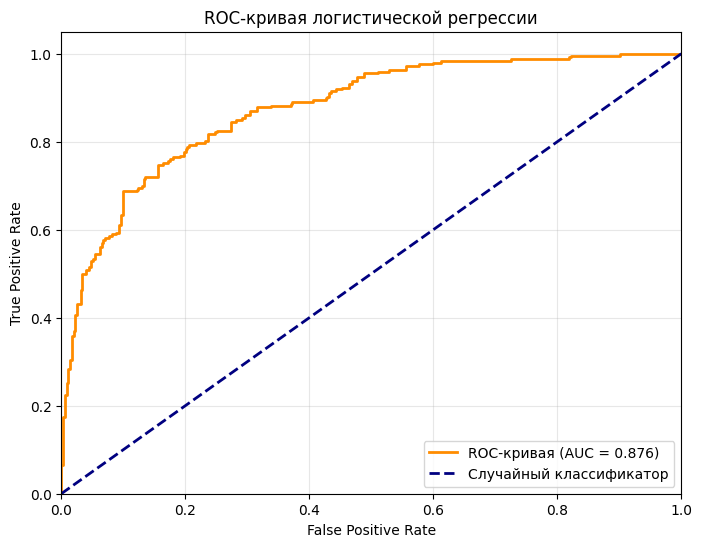


График сохранён по пути: figures/roc_curve_logreg.png


In [10]:
# Импорт необходимых библиотек
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, 
    recall_score, f1_score, confusion_matrix, 
    roc_curve, auc
)
import matplotlib.pyplot as plt

# Подготовка данных
X = df.drop(['client_id', 'default'], axis=1)
y = df['default']

# Разделение на train/test (стратифицированно, чтобы сохранить баланс классов)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Создание Pipeline: стандартизация + логистическая регрессия
pipe = Pipeline([
    ('scaler', StandardScaler()),                          # Стандартизация признаков
    ('logreg', LogisticRegression(max_iter=1000))         # Логистическая регрессия
])

# Сетка гиперпараметров для поиска
param_grid = {
    'logreg__C': [0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100.0],     # Обратная сила регуляризации
    'logreg__solver': ['liblinear', 'lbfgs']               # Два совместимых солвера
}

# GridSearchCV с кросс-валидацией и оптимизацией по ROC-AUC
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Обучение с перебором параметров
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)
print(f"Лучшее ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

# Лучшая модель
best_model = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]   # Вероятности класса 1

# Расчёт метрик
print("\nМетрики на тестовой выборке:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Построение и сохранение ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC-кривая (AUC = {roc_auc_value:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая логистической регрессии')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Сохранение графика
save_path = 'figures/roc_curve_logreg.png'
plt.savefig(save_path)
plt.show()

print(f"\nГрафик сохранён по пути: {save_path}")

In [11]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score
)

# Бейзлайн: DummyClassifier (предсказывает самый частый класс)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(y_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_prob_dummy = dummy.predict_proba(X_test)[:, 1]

# Метрики для Dummy
acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_dummy = roc_auc_score(y_test, y_prob_dummy)
prec_dummy = precision_score(y_test, y_pred_dummy, zero_division=0)
rec_dummy = recall_score(y_test, y_pred_dummy, zero_division=0)
f1_dummy = f1_score(y_test, y_pred_dummy, zero_division=0)

# Метрики для лучшей логистической регрессии (best_model из предыдущей ячейки)
y_pred_log = best_model.predict(X_test)
y_prob_log = best_model.predict_proba(X_test)[:, 1]

acc_log = accuracy_score(y_test, y_pred_log)
roc_log = roc_auc_score(y_test, y_prob_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

# Создаём таблицу результатов
results_df = pd.DataFrame({
    'Модель': ['DummyClassifier<br>(most_frequent)', 'LogisticRegression'],
    'Accuracy': [f'{acc_dummy:.4f}', f'{acc_log:.4f}'],
    'ROC-AUC': [f'{roc_dummy:.4f}', f'{roc_log:.4f}'],
    'Precision': [f'{prec_dummy:.4f}', f'{prec_log:.4f}'],
    'Recall': [f'{rec_dummy:.4f}', f'{rec_log:.4f}'],
    'F1-score': [f'{f1_dummy:.4f}', f'{f1_log:.4f}']
})

# Красивый вывод таблицы с заголовком
display(
    results_df.style
    .set_caption("Сравнение бейзлайна и логистической регрессии на тестовой выборке")
    .set_table_styles([
        {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.3em; font-weight: bold;'}
    ])
    .format(precision=4)
)

,Модель,Accuracy,ROC-AUC,Precision,Recall,F1-score
0,DummyClassifier(most_frequent),0.5900,0.5000,0.0000,0.0000,0.0000
1,LogisticRegression,0.8000,0.8757,0.7944,0.6911,0.7391


---
Бейзлайн-модель (DummyClassifier, предсказывающая самый частый класс) показывает низкое качество, поскольку не учитывает признаки и всегда игнорирует дефолты, что приводит к нулевым значениям Precision, Recall и F1-score, делая её бесполезной для выявления рисков. В отличие от неё, логистическая регрессия анализирует признаки, достигая значительно лучшего разделения классов и баланса между точностью и полнотой. Accuracy выросла с 0.5900 до 0.8000, что означает улучшение на 35% относительно бейзлайна, а ROC-AUC поднялась с 0.5000 до 0.8757, указывая на рост на 75% и переход от случайного угадывания к сильной предсказательной способности. Подбор параметра C (обратной силы регуляризации) через GridSearchCV показал, что малые значения C (например, 0.01–0.1) усиливают регуляризацию, делая модель проще и снижая ROC-AUC на кросс-валидации до 0.82–0.85, в то время как большие C (10.0–100.0) ослабляют её, рискуя переобучением, но давая пиковое качество около 0.88 при C=1.0–2.0. Оптимальное C балансирует сложность модели, избегая как недообучения, так и переобучения. Логистическая регрессия кажется разумной базовой моделью для задачи кредитного скоринга, поскольку она проста, интерпретируема и даёт высокий ROC-AUC, критичный для оценки рисков. Она превосходит бейзлайн по всем метрикам, позволяя выявлять до 69% дефолтов при приемлемой точности. Для дальнейшего улучшения можно комбинировать её с более сложными моделями, но для старта логрег достаточна благодаря своей эффективности и лёгкости реализации.
